# Exercise 1

**Group 5**:
- Elias Maria Bonasera (2149751)
- Alberto Casellato (2139206)
- Nicola Garbin (2156363)
- Francesco Pazzocco (2165861)

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import truncnorm

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop, Nadam, SGD
from keras_tuner import HyperParameters
from keras_tuner import RandomSearch
from sklearn.model_selection import KFold

mpl.rc('image', cmap='copper')

2025-03-03 21:25:47.775825: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 21:25:47.779512: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 21:25:47.790771: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741033547.810859 3235480 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741033547.816154 3235480 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 21:25:47.835036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Random search of best hyperparameters

In [2]:
class DNN:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
        self.xs = None # x standardized
        self.xs_train = None
        self.xs_valid = None
        self.y_train = None
        self.y_valid = None
        self.tuner = None
        self.best_models = None
        self.best_hps = None
        self.last_fit = None
    
    def standardize(self):
        x_mean = np.mean(self.x, axis=0)
        x_std = np.std(self.x, axis=0)

        self.xs = (self.x-x_mean)/x_std
    
    def split(self, percent_training=0.8):
        N_train = int( self.xs.shape[0] * percent_training )
        self.xs_train, self.y_train = self.xs[:N_train], self.y[:N_train]
        self.xs_valid, self.y_valid = self.xs[N_train:], self.y[N_train:]
    
    def random_search(self, build_model, epochs=3, objective="val_accuracy", 
                      max_trials=3, executions_per_trial=2, directory="results",
                      project_name="project", verbose=1, num_models=3):
        
        self.tuner = RandomSearch(
            hypermodel=build_model,
            objective=objective,
            max_trials=max_trials,
            executions_per_trial=executions_per_trial,
            overwrite=True,
            directory=directory,
            project_name=project_name
        )
        
        self.tuner.search(
            self.xs_train, self.y_train, 
            epochs=epochs, 
            validation_data=(self.xs_valid, self.y_valid),
            verbose=verbose
        )
        
        self.best_models = self.tuner.get_best_models(num_models=num_models)
        self.best_hps = self.tuner.get_best_hyperparameters(num_models)
    
    def fit(self, ix_model=0, epochs=100, batch_size=50, verbose=1):

        self.last_fit = self.best_models[ix_model].fit(
            self.xs_train, self.y_train,
            epochs = epochs, 
            batch_size = batch_size,
            validation_data = (self.xs_valid, self.y_valid),
            verbose = verbose
        )
        
    def show_train_vs_valid(self):
        fig, axes = plt.subplots(1, 2, figsize=(12,5))

        # accuracy
        axes[0].plot(self.last_fit.history["accuracy"], label="train")
        axes[0].plot(self.last_fit.history["val_accuracy"], label="valid.")
        axes[0].set_xlabel("epoch")
        axes[0].set_ylabel("accuracy")
        axes[0].legend()

        # loss
        axes[1].plot(self.last_fit.history["loss"], label="train")
        axes[1].plot(self.last_fit.history["val_loss"], label="valid.")
        axes[1].set_xlabel("epoch")
        axes[1].set_ylabel("loss")
        axes[1].legend()

        plt.show()
    

In [3]:
def build_model(hp):
    L = 8
    
    # model
    model = Sequential()
    model.add( 
        Dense(
            L, input_shape=(L,), 
            activation=hp.Choice(f"activation_0", ["sigmoid", "tanh", "relu", "elu", "leaky_relu"])
        )
    )
    
    for i in range(3):
        model.add(
            Dense(
                units=20, 
                activation=hp.Choice(f"activation_{i+1}", ["sigmoid", "tanh", "relu", "elu", "leaky_relu"])
            )
        )
        
        model.add( Dropout(rate=hp.Choice(f"rate_{i+1}", [0., 0.1, 0.2])) )
        
    model.add( Dense(units=1, activation="sigmoid") )
    
    # compile
    learning_rate = hp.Float("lr", min_value=1e-6, max_value=1e-1, sampling="log")
    optimizers = {"Adam": Adam, "RMSprop": RMSprop, "Nesterov": Nadam, "SGD": SGD}
    opt_name = hp.Choice("optimizer", list(optimizers.keys()))
    model.compile(
        optimizer=optimizers[opt_name](learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    
    return model

x = np.loadtxt("./DATA/data-for-DNN_type3_L8.dat", delimiter=" ")
y = np.loadtxt("./DATA/labels-for-DNN_type3_L8.dat", delimiter=" ")
y = y.astype("int")

In [4]:
network = DNN(x, y)
network.standardize()
network.split()
network.random_search(build_model, epochs=400, max_trials=20,
                      executions_per_trial=1, num_models=10, verbose=0)

2025-03-03 21:25:49.789737: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/alberto/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/alberto/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/alberto/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved 

In [5]:
network.fit(epochs=400, verbose=0)

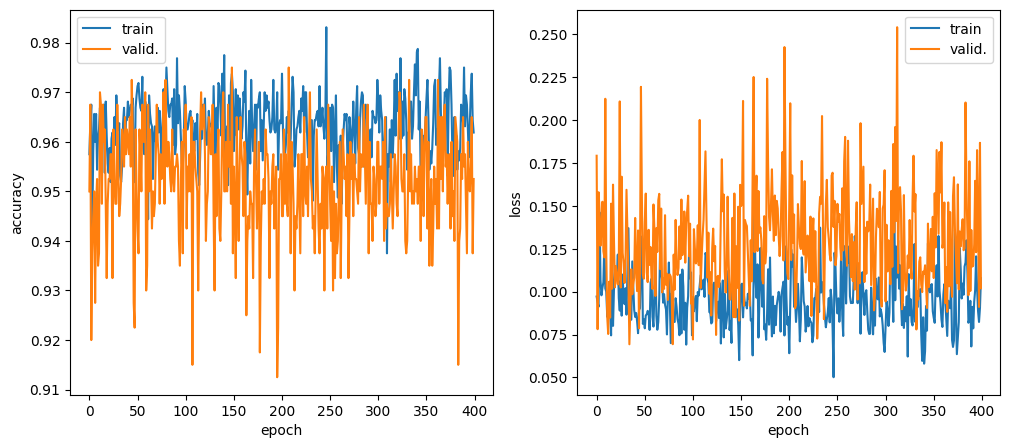

In [6]:
network.show_train_vs_valid()

There is no sign of overfitting since the validation accuracy follows the trend of the training accuracy, and also the validation loss does not increase with the number of epochs.

In [7]:
list_acc = []

for i in range(len(network.best_models)):
    network.fit(ix_model=i, verbose=0)
    acc = network.last_fit.history['accuracy'][-1]
    list_acc.append(acc)

list_ix = []
best_acc = max(list_acc)
for i, acc in enumerate(list_acc):
    if abs(acc - best_acc) < 0.1:
        list_ix.append(i)

In [8]:
def cross_validate(network, ix_model, k=5):
    kf = KFold(n_splits=k, shuffle=True)
    
    list_acc = []
    for train_index, test_index in kf.split(network.xs):
        x_train, x_test = network.xs[train_index], network.xs[test_index]
        y_train, y_test = network.y[train_index], network.y[test_index]
        network.best_models[ix_model].fit(x_train, y_train, epochs=100, batch_size=50, verbose=0)
        acc = network.best_models[ix_model].evaluate(x_test, y_test, verbose=0)
        list_acc.append(acc[1])

    return np.mean(list_acc), np.std(list_acc)

list_mean_acc = []
list_std_acc = []
best_mean_acc = 0
best_ix = 0
for i in list_ix:
    mean_acc, std_acc = cross_validate(network, i)
    list_mean_acc.append(mean_acc)
    list_std_acc.append(std_acc)
    if mean_acc > best_mean_acc:
        best_mean_acc = mean_acc
        best_ix = i

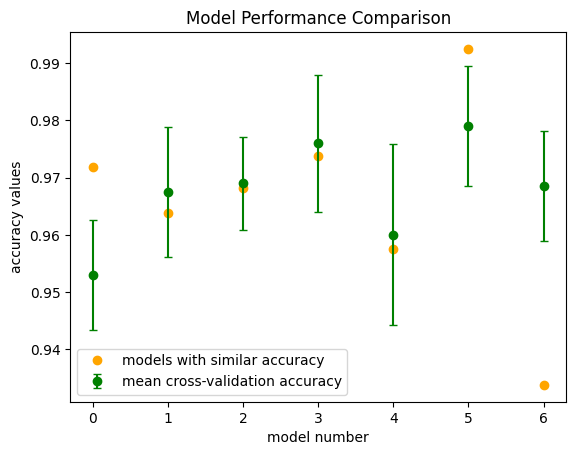

In [9]:
plt.plot(list_ix, np.array(list_acc)[list_ix], marker='o', color='orange', label='models with similar accuracy', linestyle='None')
plt.errorbar(list_ix, list_mean_acc, yerr=list_std_acc, marker='o', capsize=3, color='green', label='mean cross-validation accuracy', linestyle='None')
plt.xticks(list(range(len(list_ix))))
plt.xlabel('model number')
plt.ylabel('accuracy values')
plt.legend()
plt.title('Model Performance Comparison')
plt.show()

Most accuracy values are high, this implies that the random search was successful in finding good sets of hyperparameters. The presence of green dots near orange dots suggests that those models generalize well.

In [10]:
for i in list_ix:
    print(f"Model {i}: {network.best_hps[i].values}\n")

Model 0: {'activation_0': 'leaky_relu', 'activation_1': 'relu', 'rate_1': 0.1, 'activation_2': 'tanh', 'rate_2': 0.0, 'activation_3': 'leaky_relu', 'rate_3': 0.1, 'lr': 0.015047492635079592, 'optimizer': 'Adam'}

Model 1: {'activation_0': 'leaky_relu', 'activation_1': 'relu', 'rate_1': 0.2, 'activation_2': 'leaky_relu', 'rate_2': 0.0, 'activation_3': 'sigmoid', 'rate_3': 0.1, 'lr': 0.00460722487105426, 'optimizer': 'RMSprop'}

Model 2: {'activation_0': 'leaky_relu', 'activation_1': 'relu', 'rate_1': 0.2, 'activation_2': 'tanh', 'rate_2': 0.1, 'activation_3': 'sigmoid', 'rate_3': 0.2, 'lr': 0.0018055176622686156, 'optimizer': 'Nesterov'}

Model 3: {'activation_0': 'relu', 'activation_1': 'relu', 'rate_1': 0.1, 'activation_2': 'relu', 'rate_2': 0.2, 'activation_3': 'sigmoid', 'rate_3': 0.2, 'lr': 0.0006153731254693113, 'optimizer': 'Nesterov'}

Model 4: {'activation_0': 'leaky_relu', 'activation_1': 'elu', 'rate_1': 0.0, 'activation_2': 'sigmoid', 'rate_2': 0.2, 'activation_3': 'leaky_re

Observing the hyperparameters of models with similar accuracy, we can see that Adam and is the one that appears the most. The trend we can see in the activation functions is that for the input layer there are mainly the Leaky ReLU and ReLU as activation functions, and for the first hidden layer the ReLU. As for the learning rates, they are all greater than $10^{-4}$.

## Data augmentation

In this class a data augmentation is performed adding random noise to each point of the dataset.

In [11]:
C           = ["L1", "L2", "L3", "L4", "L5", "L6", "L7", "L8"]
label       = "label"
df          = pd.DataFrame(x, columns = C)
df["label"] = y
#
# making plot
def making_plot(columns, values, title, xlabel, ylabel):
    plt.figure(figsize = (10, 6))
    plt.bar(columns, values, color = 'skyblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(0.85, 1)
    plt.xticks(rotation = 45)
    plt.grid()
    plt.show()
    #
#####

Text(0, 0.5, 'L2')

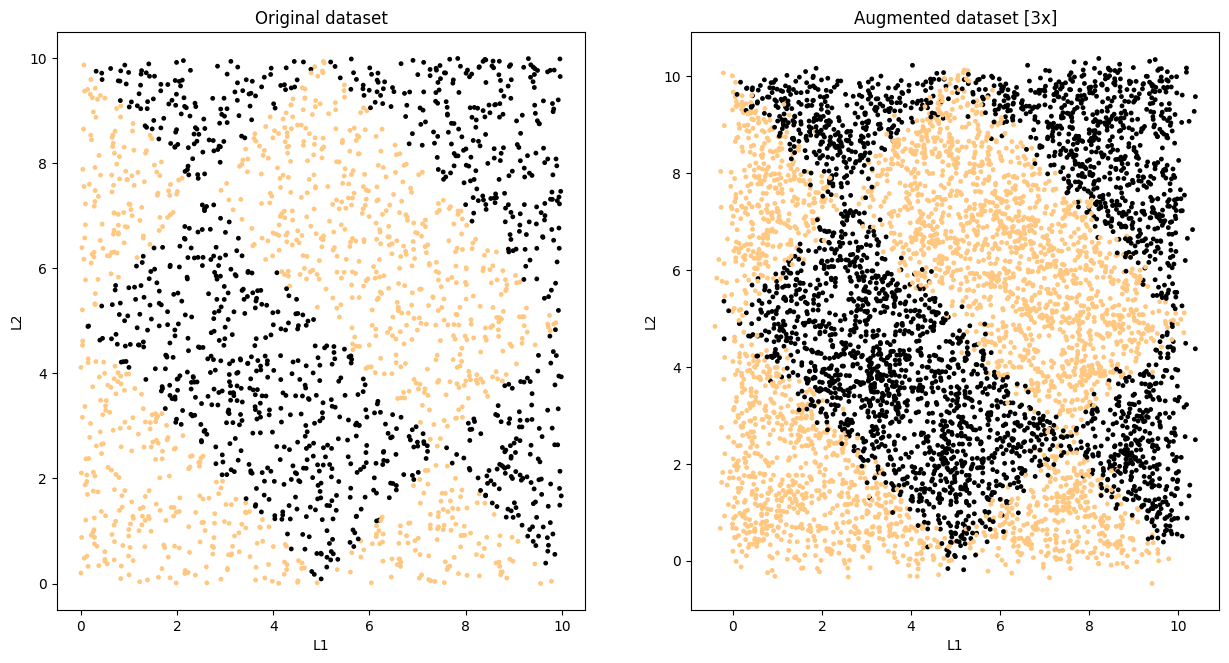

In [12]:
# metric
def metric(df, i, chosen = 1):
    tmp = np.array(df[C]) - np.array(df[i:i+1][C])
    tmp = abs(tmp).mean(axis = 1)
    tmp.sort()
    return tmp[chosen] / 2
    #
#####
#
# points generator
class POINTS(object):
    def __init__(self, df):
        self.df     = df
        self.new_df = None
        #
    #####
    #
    def run(self, N = 1, spread = 1):
        points = pd.DataFrame([])
        for i in range(len(self.df)):
            std  = metric(df, i, spread)
            th   = (2 * std) / std
            new_points = truncnorm.rvs(- 0.75, 0.75, loc = 0, scale = std, size = (N, 8)) + np.array(df[C].iloc[i])
            new_points = pd.DataFrame(new_points, columns = C)
            new_points[label] = df[label].iloc[i]
            points     = pd.concat([points, new_points], ignore_index = True)
            #
        #####
        #
        self.new_df = points
        #
    #####
    #
    def print(self):
        return pd.concat([self.df, self.new_df], ignore_index = True)
        #
    #####
    #
#####

m = POINTS(df)
m.run(N = 2, spread = 2)
new_df = m.print()

x_new, y_new = np.array(new_df[C]), np.array(new_df["label"])

# plotting of new generated and original data
fig,  axs = plt.subplots(1, 2, figsize = (15, 7.5))
axs[0].scatter(x[:, 0],     x[:, 1],     s = 6, c = y)
axs[1].scatter(x_new[:, 0], x_new[:, 1], s = 6, c = y_new)
axs[0].set_title("Original dataset")
axs[1].set_title("Augmented dataset [3x]")
axs[0].set_xlabel("L1")
axs[1].set_xlabel("L1")
axs[0].set_ylabel("L2")
axs[1].set_ylabel("L2")

### Reducing and Increasing
In the following a fit is performed both reducing and increasing the size of the dataset

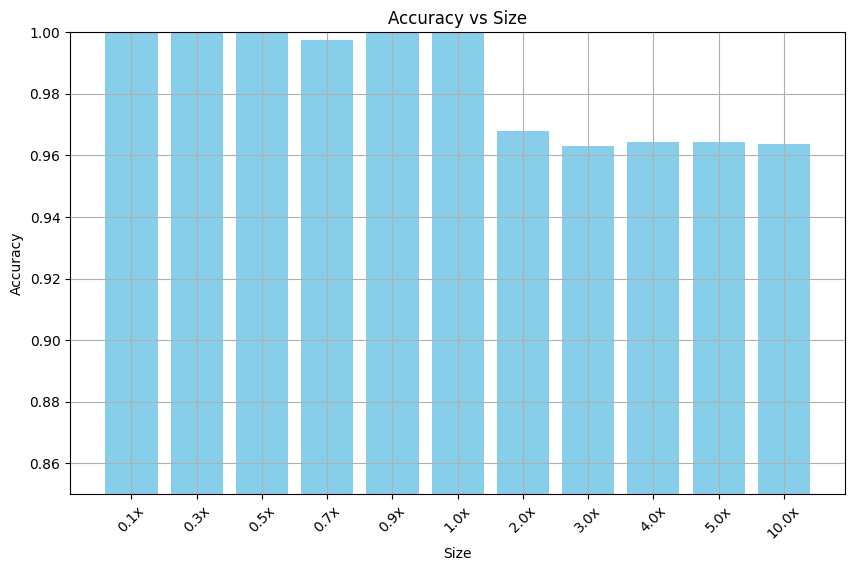

In [13]:
esit = []

for p in [0.1, 0.3, 0.5, 0.7, 0.9, 1]:
    if p == 1:
        x_r = x
        y_r = y
    else:
        N_r = int(p * len(x))
        x_r = x[:N_r]
        y_r = y[:N_r]
        #
    #####
    #
    network.x = x_r
    network.y = y_r
    network.standardize()
    network.split()
    network.fit(ix_model = best_ix, verbose = 0)
    esit += [[p, network.last_fit.history['accuracy'][-1]]]
    #
#####
#

for p in [1, 2, 3, 4, 9]:
    m.run(N = p, spread = 2)
    new_df = m.print()
    #
    x_a = new_df[C].to_numpy()
    y_a = new_df[label].to_numpy()
    network.x = x_a.astype(float)
    network.y = y_a.astype(int)
    #
    network.standardize()
    network.xs_valid, network.y_valid = network.xs[:400], network.y[:400]
    network.xs_train, network.y_train = network.xs[400:], network.y[400:]
    network.fit(ix_model = best_ix, verbose = 0)
    esit += [[p + 1, network.last_fit.history['accuracy'][-1]]]
    #
#####
#

esit = np.array(esit).T
making_plot([str(p) + "x" for p in esit[0]], esit[1], title = "Accuracy vs Size", xlabel = "Size", ylabel = "Accuracy")

In this last graph, we can observe that the model's accuracy tends to decrease as the size of the training set increases beyond 1x, while it remains stable for sizes below the original one. This behavior appears to be related to the nature of the growing algorithm: the new generated points are distributed across a neighborhood of each existing point. These fluctuations result in less distinct boundaries between different regions, which seems to negatively impact accuracy.